## Import the CSV Data

In [1]:
import pandas as pd
import glob

# Define the range of legislative sessions
sessions = range(123, 126)  # 118 to 125 inclusive

# Create a list to store DataFrames
df_list = []

# Load each CSV and append to the list
for session in sessions:
    file_path = f"../data/bills/{session}th_assembly_bills.csv"
    df = pd.read_csv(file_path)
    df_list.append(df)

# Concatenate all DataFrames into a single one
df_legislation = pd.concat(df_list, ignore_index=True)
print(df_legislation.head()["url"])

# Keep only relevant columns and create context
df_Bill = df_legislation[["bill_id", "title", "description"]].copy()
df_Bill["context"] = df_Bill["title"] + " " + df_Bill["description"]

# # Save to a single CSV (optional)
# df_Bill.to_csv("../data/all_sessions_bills.csv", index=False)

df_Bill.head()

0    https://legiscan.com/SC/bill/H3020/2019
1    https://legiscan.com/SC/bill/H3024/2019
2    https://legiscan.com/SC/bill/H3029/2019
3    https://legiscan.com/SC/bill/H3030/2019
4    https://legiscan.com/SC/bill/H3031/2019
Name: url, dtype: object


,bill_id,title,description,context
0,1134391,SC Fetal Heartbeat Protection from Abortion Act,"Amend The Code Of Laws Of South Carolina, 1976...",SC Fetal Heartbeat Protection from Abortion Ac...
1,1134384,General Assembly term limits,"Amend The Code Of Laws Of South Carolina, 1976...",General Assembly term limits Amend The Code Of...
2,1134554,Executive Committee,"Amend Section 7-17-560, Code Of Laws Of South ...","Executive Committee Amend Section 7-17-560, Co..."
3,1134434,Parking violation tickets,"Amend Section 56-3-1971, Code Of Laws Of South...",Parking violation tickets Amend Section 56-3-1...
4,1134473,Voter registration,"Amend Section 7-5-150, Code Of Laws Of South C...","Voter registration Amend Section 7-5-150, Code..."


## Downloading Documents

In [2]:
import requests 
import os
import json
import re
from weasyprint import HTML
from base64 import b64decode

# Insert LegiScan API key here
apiKey = "45932db20ec30384bc3347de3c1adeee"
urls = {}

# Create a dictionary with bill ids and their api urls
for index, row in df_Bill.head().iterrows():
    urls[row["bill_id"]] = f"https://api.legiscan.com/?key={apiKey}&op=getBill&id={row["bill_id"]}"

# Set up the path for the pdfs
savePath = "../data/billDocs"
os.makedirs(savePath, exist_ok=True)
pdfs = []

# Request and convert full text data to pdfs
for billID, url in urls.items():
    # Request bill information
    response = requests.get(url)
    if response.json()["bill"]["texts"]:
        # Get the most recent document id
        docID = response.json()["bill"]["texts"][0]["doc_id"]

        # Request the document text
        urls[billID] = f"https://api.legiscan.com/?key={apiKey}&op=getBillText&id={docID}"
        response = requests.get(urls[billID])

        # Decode and convert the html text to a pdf format
        pdfPath = os.path.join(savePath, f"{billID}.pdf")
        billText = str(b64decode(response.json()["text"]["doc"], validate=True))
        pdfText = HTML(string=billText).write_pdf()

        # Save the text data to a pdf 
        with open(pdfPath, "wb") as file:
            file.write(pdfText)
            pdfs.append(pdfPath)
            print(f"Successfully downloaded {billID}.pdf")

Successfully downloaded 1134391.pdf
Successfully downloaded 1134384.pdf
Successfully downloaded 1134554.pdf
Successfully downloaded 1134434.pdf
Successfully downloaded 1134473.pdf


## Convert PDFs to Images 

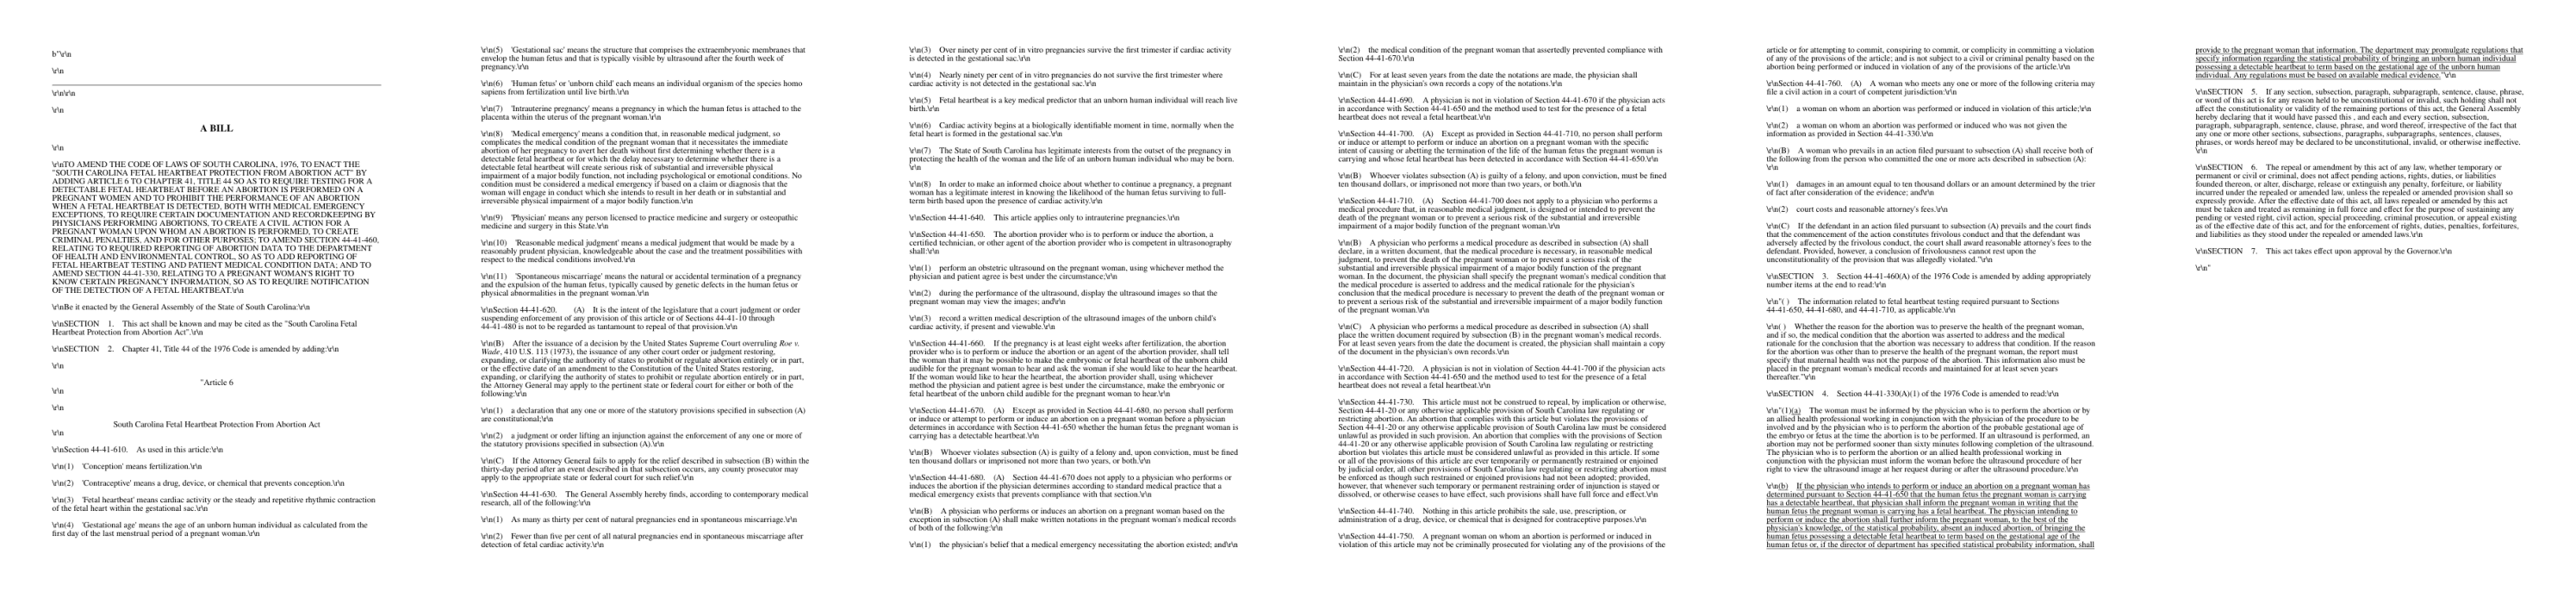

In [21]:
from pdf2image import convert_from_path
import matplotlib.pyplot as plt
import fitz

images = {}

# Save a dictionary of images of the pdf pages
for pdf in pdfs:
    doc = fitz.open(pdf)
    images[pdf] = []
    for page in doc:
        pixmap = page.get_pixmap()
        images[pdf].append(pixmap.pil_image())

# Plot the first bill's images
fig, axes = plt.subplots(1, len(images[pdfs[0]]), figsize=(30, 30))

for i, ax in enumerate(axes.flat):
    img = images[pdfs[0]][i]
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show()